# Segmentation Modelling Notebook

## Introduction
This notebook contains the unsupervised modelling for segmentation. The data used comes after the preprocessinig done by the `preprocessing.py` file. The call for preprocessing was done via Terminal 

## Context/ Business Goal
The targeted company for this project is an **Organics** company that is selling **mail-ordered** products.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans

import matplotlib.ticker as mtick

import pickle

In [2]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('whitegrid')

In [3]:
CENSUS_PATH = 'data/refined/full_census_data_final.parquet'

CUSTOMER_PATH = 'data/refined/full_customer_data_final.parquet'

In [4]:
census = pd.read_parquet(CENSUS_PATH)

In [5]:
census.head()

,LNR,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,11.0,0,0,2.0,12.0,0.0,3,6,36,...,6,1,3,2,3,9,4,5,2,1
2,910225,10.0,0,0,1.0,7.0,0.0,3,2,16,...,3,4,2,1,3,9,2,5,2,3
3,910226,1.0,0,0,0.0,2.0,0.0,2,4,6,...,4,4,1,1,6,9,7,3,2,4
4,910241,3.0,0,0,4.0,3.0,0.0,4,2,26,...,2,7,2,2,2,9,3,4,1,3
5,910244,5.0,0,0,1.0,2.0,0.0,2,6,38,...,6,2,0,2,6,9,7,4,2,1


In [6]:
census_var_types = pd.read_csv('data/trusted/var_type_list.csv')

In [7]:
census.shape

(785414, 302)

In [8]:
census_var_types['Type'].value_counts()

interval    300
nominal      19
numeric      11
binary        9
Name: Type, dtype: int64

Variables considered as interval could be used in PCA. Unfortunately, this approach is not enough to handle nominal and binary features.  
An alteranitve approach to solve this problem is [Factorial Analysis of Mixed Data (FAMD)](https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210).  
Using this approach, we will reduce the dimensions of the mixed data types prior to clustering it.

# Utils

In [9]:
def get_dummy_var_names(nom_var_list,data):

    '''
    Gets a list of dummy variables names after OHE
    :param nom_var_list: nominal variables' names prior to OHE
    :param data: data

    :return: list with dummy variables' names
    '''

    dummy_nominal_vars = []

    for name in list(nom_var_list):

        for col in data.columns:

            if name in col:

                dummy_nominal_vars.append(col)

    # Fix for GEBAEUDETYP and GEBAUDETYP_RASTER
    dummy_nominal_vars = sorted(list(set(dummy_nominal_vars)))

    return dummy_nominal_vars

def weight_encoded_col(col):

    '''
    Generates weights according to FAMD implementation. Works in binary variables.
    The weight is given as the division of the 1 values by the square-root of the probability of occurance of the effect in the column.

    :param col: column to be adjusted

    :return col: column after adjustments
    '''

    # mean = probability of occurance for a binary col
    mean = col.mean()

    weight = np.sqrt(mean)

    col = col / weight
    
    # Centering
    center_ref = col.mean()

    col = col - center_ref
    
    return col

def prep_data_famd(data, nom_var_list, binary_var_list, num_col_list):

    '''
    Preparates the data for FAMD approach

    :param data: data
    :param nom_var_list: nominal variables' names prior to OHE
    :param binary_var_list: binary variables' names

    :return data: transformed data according to FAMD
    '''

    data = pd.get_dummies(data, columns = list(nom_var_list))

    dummy_names = get_dummy_var_names(nom_var_list, data)

    for col in list(binary_var_list) + list(dummy_names):
        
        try:

            data[col] = weight_encoded_col(data[col])

        except:
        
            print('Col Not Found:',col)
            
            # Equivalent to handle_unknown = ignore in sklearn
            data[col] = 0
        
    scaler = StandardScaler()

    data[num_col_list] = scaler.fit_transform(data[num_col_list])

    return data

# Clustering demographic data

## Adjustments to nominals and binaries

In [10]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, census.columns)

In [11]:
for col in binary_vars:
    
    try:
        print(col, census[col].unique())

    except:

        print(f'Column not found: {col}')

        continue

ANREDE_KZ [2 1]
ANZ_HH_TITEL [0 1]
ANZ_KINDER [0 1]
GREEN_AVANTGARDE [0 1]
KBA05_SEG6 [1 0]
OST_WEST_KZ [1 0]
VERS_TYP [2 1]


In [12]:
census['ANREDE_KZ'] = census['ANREDE_KZ'] - 1

census['VERS_TYP'] = census['VERS_TYP'] - 1

## Defining groups of columns

In [13]:
nominal_vars = census_var_types[census_var_types['Type'] == 'nominal']['Attribute'].values

nominal_vars = np.intersect1d(nominal_vars, census.columns)

In [14]:
interval_vars = census_var_types[census_var_types['Type'] == 'interval']['Attribute'].values

interval_vars = np.intersect1d(interval_vars, census.columns)

In [15]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, census.columns)

In [16]:
num_cols = census.columns.drop(list(nominal_vars) + list(binary_vars) + list(interval_vars) + ['LNR'])

In [17]:
assert (len(nominal_vars) + len(binary_vars) + len(interval_vars) + len(num_cols) + 1) == census.shape[1]

# PCA + KMeans
- FAMD Implementation
- Using K-Means so we can leverage the centroid position to predict the populations' clusters without necessarily having to cluster the whole population

In [18]:
# Prepping full data
census = prep_data_famd(census, nominal_vars, binary_vars, num_col_list=num_cols)

In [19]:
# Notice that now we have completely numerical interpretations of all features. This we can use in a PCA
census.head()

,LNR,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,NATIONALITAET_KZ_3,RETOURTYP_BK_S_1,RETOURTYP_BK_S_2,RETOURTYP_BK_S_3,RETOURTYP_BK_S_4,RETOURTYP_BK_S_5,SHOPPER_TYP_0,SHOPPER_TYP_1,SHOPPER_TYP_2,SHOPPER_TYP_3
1,910220,0.174630,-0.172784,-0.325778,0.230033,0.310465,-0.060395,3,6,36,...,-0.201877,2.154177,-0.337693,-0.467214,-0.392562,-0.599499,-0.400526,-0.595807,-0.508999,1.630904
2,910225,0.110217,-0.172784,-0.325778,-0.632277,-0.041772,-0.060395,3,2,16,...,-0.201877,-0.392646,-0.337693,1.673134,-0.392562,-0.599499,-0.400526,-0.595807,1.455642,-0.474882
3,910226,-0.469495,-0.172784,-0.325778,-1.494587,-0.394009,-0.060395,2,4,6,...,-0.201877,-0.392646,2.623575,-0.467214,-0.392562,-0.599499,-0.400526,1.082589,-0.508999,-0.474882
4,910241,-0.340670,-0.172784,-0.325778,1.954654,-0.323562,-0.060395,4,2,26,...,-0.201877,-0.392646,-0.337693,-0.467214,-0.392562,1.068561,-0.400526,-0.595807,1.455642,-0.474882
5,910244,-0.211845,-0.172784,-0.325778,-0.632277,-0.394009,-0.060395,2,6,38,...,-0.201877,-0.392646,-0.337693,1.673134,-0.392562,-0.599499,2.096190,-0.595807,-0.508999,-0.474882


# PCA

**Warning: Running the cell below might take a while. Beware of that**

In [23]:
explained_var_list_step = []

for comp in range(125,325, 50):

    print(f'Running for {comp} components...')
    pca = PCA(n_components=comp, random_state=123)

    pca.fit(census.drop(columns = 'LNR'))

    expl_variance = pca.explained_variance_ratio_.sum()

    print(f'Explained Variance: {expl_variance}', end = '\n\n')
    
    explained_var_list_step.append(expl_variance)

    if expl_variance >= 0.95:

        break
    # explained_var_list.append(explained_var_list_step_2)

Running for 125 components...
Explained Variance: 0.874553367326486

Running for 175 components...
Explained Variance: 0.9277054809752024

Running for 225 components...
Explained Variance: 0.9634138483202088



Text(0.5, 1.0, 'Percent of Explained Variance by Amount of Components')

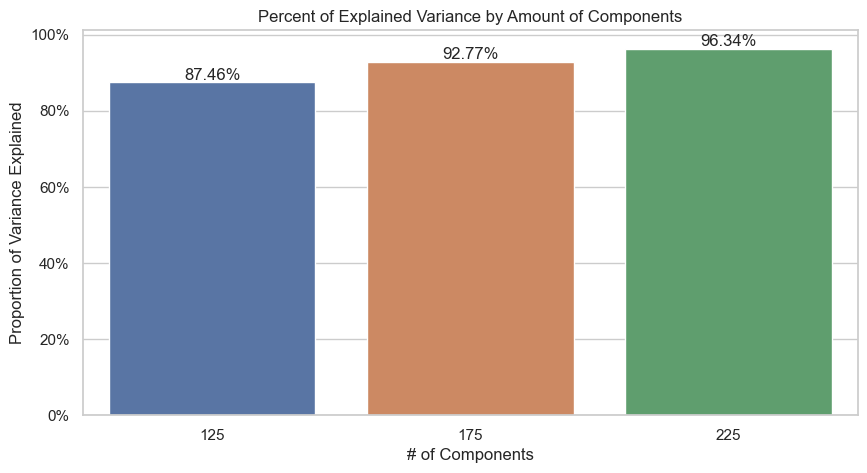

In [44]:
fig, ax = plt.subplots(figsize = (10,5))

sns.barplot(x = [i for i in range(125,275,50)],
             y = explained_var_list_step,
             ax = ax)

ax.set_xlabel('# of Components')

ax.set_ylabel('Proportion of Variance Explained')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))

ax.bar_label(ax.containers[0], labels = [f'{v:.2%}' for v in explained_var_list_step])

plt.title('Percent of Explained Variance by Amount of Components')

# K-Means

800k entries is too much for some machines to handle and/or take a long time for the algorithm to run.  
Therefore, assuming the AZDIAS data as the population we want to model for, we will use a sample of it to find the centroids of our clusters to then propagate this information.  
Using a simple [Sample Size Calculator](https://www.calculator.net/sample-size-calculator.html?type=1&cl=99.9&ci=1&pp=50&ps=891221&x=0&y=0), assuming a homogenous population we can find that starting from 5000 random samples we can have a good enough representation of the general population.

In [20]:
def score_kmeans(X,k_range):

    '''
    Function that iteratively scores K-Means based on point distance to centroids.

    :param X: Data that the Kmeans should be fitted to
    :param k_range: range to be used for experimentation.

    :return dist_list: List of total inertia for each step in the ranges
    '''

    for i, k in enumerate(k_range):

        print(f'Running for K = {k} Clusters...')

        # Using MiniBatch for performance
        kmeans = MiniBatchKMeans(n_clusters=k,
                                    init = 'k-means++',
                                    random_state=123,
                                    batch_size=2048,
                                    max_iter=50,
                                    n_init = 3)

        kmeans.fit(X)

        if i == 0:

            dist_list = [kmeans.inertia_]
        
        else:

            dist_list.append(kmeans.inertia_)

    return dist_list

In [21]:
pca = PCA(n_components=225, random_state=123)

pca.fit(census.drop(columns = 'LNR'))

X = pca.transform(census.drop(columns = 'LNR'))

In [22]:
k_range = range(2,21)

In [23]:
distances = score_kmeans(X, k_range)

Running for K = 2 Clusters...


Running for K = 3 Clusters...
Running for K = 4 Clusters...
Running for K = 5 Clusters...
Running for K = 6 Clusters...
Running for K = 7 Clusters...
Running for K = 8 Clusters...
Running for K = 9 Clusters...
Running for K = 10 Clusters...
Running for K = 11 Clusters...
Running for K = 12 Clusters...
Running for K = 13 Clusters...
Running for K = 14 Clusters...
Running for K = 15 Clusters...
Running for K = 16 Clusters...
Running for K = 17 Clusters...
Running for K = 18 Clusters...
Running for K = 19 Clusters...
Running for K = 20 Clusters...


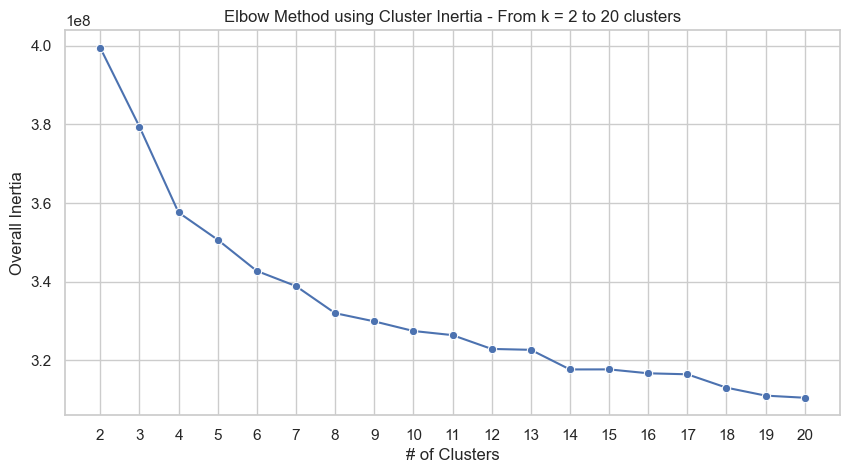

In [30]:
sns.lineplot(x = range(2,len(distances) + 2),
             y = distances,
             marker = 'o')

plt.xlabel('# of Clusters')

plt.xticks(ticks = range(2,len(distances) + 2))

plt.ylabel('Overall Inertia')

plt.title('Elbow Method using Cluster Inertia - From k = 2 to 20 clusters')

plt.show()

## Instantiating selected clustering method

In [32]:
kmeans_model = MiniBatchKMeans(n_clusters=14,
                                init = 'k-means++',
                                random_state=123,
                                batch_size=2048,
                                max_iter=50,
                                n_init = 3)

kmeans_model.fit(X)

MiniBatchKMeans(batch_size=2048, max_iter=50, n_clusters=14, n_init=3,
                random_state=123)

In [45]:
# with open('models/demographic_clusters.pkl','wb') as file:

#     pickle.dump(kmeans_model, file)

# Comparing Datasets

## Customer data Preprocessing

In [33]:
customers = pd.read_parquet(CUSTOMER_PATH)

In [34]:
customers = prep_data_famd(customers, nominal_vars, binary_vars, num_cols)

In [35]:
X_cust = customers.drop(columns = ['LNR','CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])

na_cols = set(census.columns) - set(customers.columns)

print(f'Categories not in customer data but are in census: {na_cols}')

for col in na_cols:
    
    X_cust[col] = 0

Categories not in customer data but are in census: {'GEBAEUDETYP_5'}


In [36]:
set(census.columns.drop('LNR')) == set(X_cust.columns)

True

In [37]:
X_cust = pca.transform(X_cust[census.columns.drop('LNR')]) # Order needs to be the same

In [38]:
customers['cluster'] = kmeans_model.predict(X_cust)

In [39]:
census['cluster'] = kmeans_model.predict(X)

## Plotting Comparison

In [40]:
cluster_prop_plot = pd.concat([customers['cluster'].value_counts(normalize = True),
                                census['cluster'].value_counts(normalize = True)],
                                axis = 1)

cluster_prop_plot.columns = ['customers','azdias']

cluster_prop_plot = cluster_prop_plot.melt(ignore_index=False)

cluster_prop_plot.reset_index(inplace = True)

# cluster_prop_plot

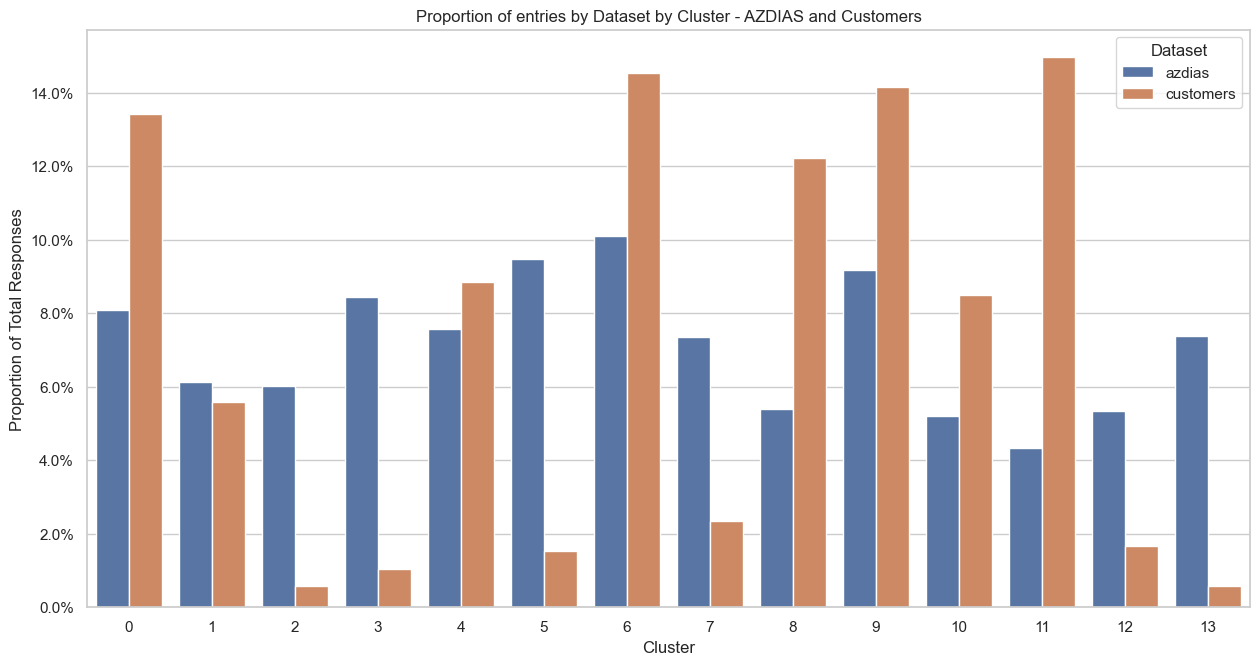

In [50]:
fig, ax = plt.subplots(figsize = (15,7.5))

g = sns.barplot(
                    data = cluster_prop_plot,
                    x = 'index',
                    y = 'value',
                    hue = 'variable',
                    hue_order=['azdias','customers'],
                    ax = ax
                )

g.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))

plt.title('Proportion of entries by Dataset by Cluster - AZDIAS and Customers')

plt.xlabel('Cluster')

plt.ylabel('Proportion of Total Responses')

plt.legend(title = 'Dataset')

plt.show()

As we can see from the plot. It looks like the clusters 0, 3, 4 and 9 are those who concentrate more customers profile. People that are assigned in those clusters are more likely to turn into potential leads.  

## Cluster interpretations

In [79]:
def get_main_components(cluster_model = kmeans_model, n_largest = 5, cluster_id = 0, return_frame = False):

    '''
    Lists main components for a given cluster in 'cluster_id' in a given model. A main component is considered a component that is centered away from 0 in either direction (positive or negative).
    Defaults to the 5 largest distances from 0.
    To work, the clustering method needs to have distance-based centroids.

    :param cluster_model: Clustering model (WITH CENTROIDS) to be evaluated for components.
    :param n_largest: Number of components to return for a cluster
    :param cluster_id: Id (index) of the cluster
    :param return_frame: Boolean to define if whole dataframe needs to be returned.
    
    :return temp: Full dataframe with components' coordinates
    :return main_components: Frame with only the n_largest defined amount of componets
    '''

    temp = pd.DataFrame(cluster_model.cluster_centers_[cluster_id],
                        columns=['component_coordinate'])
    
    temp['abs_comp_coordinate'] = temp['component_coordinate'].abs()

    if return_frame:

        return temp
    
    else:

        main_components = temp.nlargest(columns = 'abs_comp_coordinate', n = n_largest)

    return main_components

def describe_component(component_id, base_df = census, n_features = 10, pca_object = pca, return_frame = False):

    '''
    Describes a component within the PCA. Defaults to the 10 features with largest ABSOLUTE indices.

    :param component_id: Id (index) of the component
    :param base_df: Frame with the column names used in the PCA
    :param n_features: Amount of features to be extracted - Defaults to 10
    :param pca_object: PCA fitted on the base_df
    :param return_frame: Boolean that indicates if the whole variable list of indices should be returned

    :return weights_frame: Complete frame with all indices by variable:
    :return weights_frame.nlargest: Frame subsetted to only n biggest absolute indices
    '''

    base_dict = dict(zip(base_df.columns.drop('cluster'),
                         pca.components_[component_id]))
    
    weights_frame = pd.DataFrame.from_dict(base_dict, orient = 'index', columns = ['pca_weight'])

    if return_frame:

        return weights_frame
    
    else:

        weights_frame['abs_pca_weight'] = weights_frame['pca_weight'].abs()

        return weights_frame.nlargest(n_features, columns = 'abs_pca_weight')

def plot_component_main_features(component_id):

    temp = describe_component(component_id)

    fig, ax = plt.subplots(figsize = (5, 2))

    sns.barplot(data = temp.reset_index(),
                x = 'index',
                y = 'pca_weight',
                ax = ax)

    plt.xticks(rotation = 45, fontsize = 'xx-small')

    plt.xlabel('')

    plt.ylabel('')

    plt.title(f'Component {component_id}', fontsize = 8)

    plt.show()
    
def describe_cluster(cluster_id, n_top_components = 3):

    main_comps = get_main_components(cluster_id=cluster_id, n_largest = n_top_components)

    print(f'Cluster {cluster_id} main components:')

    display(main_comps)

    top_comps = main_comps.index[0:n_top_components].to_list()

    for comp in top_comps:

        print(f'Top 10 Main features for Component {comp}:')
        
        temp = describe_component(component_id = comp)

        display(temp.style.background_gradient(subset = 'pca_weight'))

        plot_component_main_features(component_id = comp)

        print(end = '\n\n')    

Cluster 11 main components:


,component_coordinate,abs_comp_coordinate
0,29.720759,29.720759
3,3.301160,3.301160
1,2.566489,2.566489
2,-2.429924,2.429924
5,2.010527,2.010527
4,1.089204,1.089204
8,-0.852703,0.852703
6,-0.653272,0.653272
7,0.598228,0.598228
10,-0.575346,0.575346


Top 10 Main features for Component 0:


,pca_weight,abs_pca_weight
CAMEO_DEUG_2015,-0.726552,0.726552
BALLRAUM,-0.638882,0.638882
CAMEO_DEU_2015,-0.127752,0.127752
KONSUMNAEHE,0.059042,0.059042
GREEN_AVANTGARDE,-0.053097,0.053097
ONLINE_AFFINITAET,-0.047794,0.047794
LP_LEBENSPHASE_GROB,0.043850,0.043850
MIN_GEBAEUDEJAHR,0.043142,0.043142
KBA05_ANHANG,0.040611,0.040611
PLZ8_ANTG4,-0.038934,0.038934


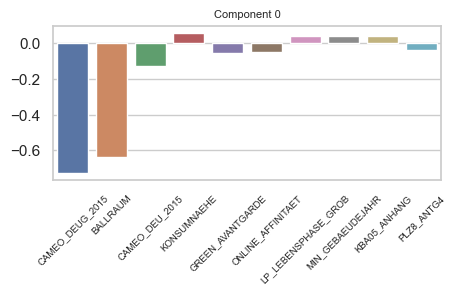



Top 10 Main features for Component 3:


,pca_weight,abs_pca_weight
KONSUMNAEHE,0.419297,0.419297
SEMIO_FAM,0.210266,0.210266
RELAT_AB,0.203595,0.203595
SEMIO_ERL,-0.179074,0.179074
SEMIO_KRIT,-0.176735,0.176735
SEMIO_TRADV,-0.171175,0.171175
VERS_TYP,-0.165291,0.165291
CAMEO_DEUINTL_2015,-0.150923,0.150923
SEMIO_REL,-0.138533,0.138533
MOBI_REGIO,0.134841,0.134841


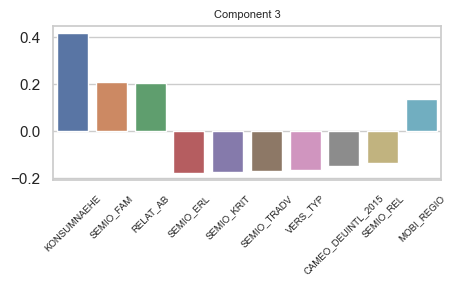



Top 10 Main features for Component 1:


,pca_weight,abs_pca_weight
PLZ8_HHZ,-0.566559,0.566559
SEMIO_MAT,-0.210485,0.210485
SEMIO_RAT,-0.210156,0.210156
FINANZ_MINIMALIST,-0.197584,0.197584
SEMIO_SOZ,-0.188069,0.188069
SEMIO_KULT,0.182344,0.182344
CJT_TYP_1,-0.181500,0.181500
FINANZ_UNAUFFAELLIGER,0.173272,0.173272
CJT_KATALOGNUTZER,-0.172918,0.172918
CJT_TYP_4,0.161653,0.161653


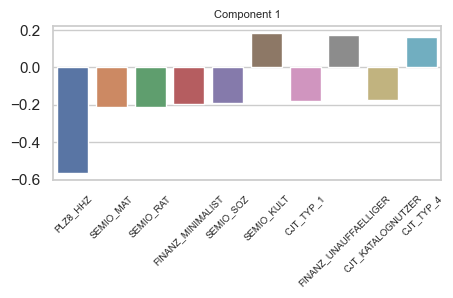



Top 10 Main features for Component 2:


,pca_weight,abs_pca_weight
KONSUMNAEHE,-0.467316,0.467316
ONLINE_AFFINITAET,0.240347,0.240347
ARBEIT,-0.199916,0.199916
D19_WEIN_FEINKOST_RZ,0.185437,0.185437
HH_EINKOMMEN_SCORE,-0.180393,0.180393
WOHNDAUER_2008,-0.151105,0.151105
VERS_TYP,0.149488,0.149488
CAMEO_DEUG_2015,-0.140326,0.140326
KKK,-0.123679,0.123679
MOBI_REGIO,-0.122604,0.122604


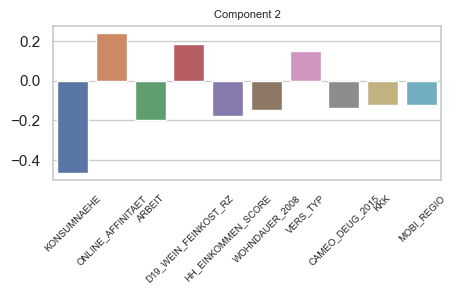



Top 10 Main features for Component 5:


,pca_weight,abs_pca_weight
ONLINE_AFFINITAET,0.314144,0.314144
HH_EINKOMMEN_SCORE,-0.261824,0.261824
ARBEIT,-0.228184,0.228184
D19_WEIN_FEINKOST_RZ,0.216618,0.216618
KONSUMNAEHE,0.164012,0.164012
CAMEO_DEUG_2015,-0.160025,0.160025
WOHNDAUER_2008,-0.157763,0.157763
PLZ8_ANTG4,0.147114,0.147114
KBA13_KMH_140_210,-0.133775,0.133775
KBA13_CCM_2500,-0.130781,0.130781


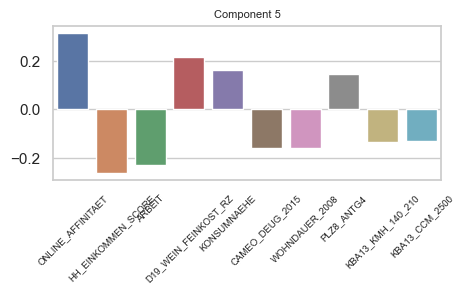



Top 10 Main features for Component 4:


,pca_weight,abs_pca_weight
SEMIO_TRADV,0.321611,0.321611
SEMIO_FAM,-0.294827,0.294827
SEMIO_REL,0.268780,0.268780
SEMIO_ERL,0.257729,0.257729
SEMIO_KRIT,0.257570,0.257570
RELAT_AB,-0.251200,0.251200
SEMIO_KAEM,-0.246935,0.246935
KONSUMNAEHE,0.207759,0.207759
SEMIO_DOM,-0.205515,0.205515
EWDICHTE,-0.121067,0.121067


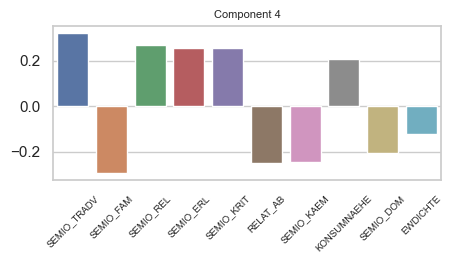



Top 10 Main features for Component 8:


,pca_weight,abs_pca_weight
CAMEO_DEUG_2015,0.351027,0.351027
BALLRAUM,-0.334136,0.334136
MIN_GEBAEUDEJAHR,0.157948,0.157948
KBA13_BMW,0.151793,0.151793
KBA05_ANHANG,0.149279,0.149279
KONSUMNAEHE,-0.143556,0.143556
WOHNDAUER_2008,-0.141413,0.141413
KBA05_MAXVORB,0.133636,0.133636
KBA05_KW3,0.125994,0.125994
KBA13_KW_40,0.123891,0.123891


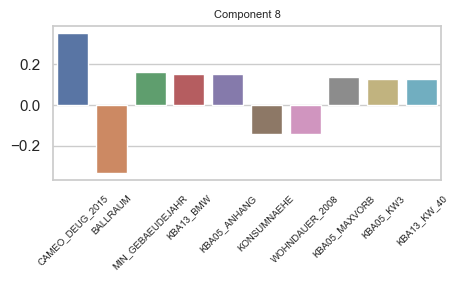



Top 10 Main features for Component 6:


,pca_weight,abs_pca_weight
CAMEO_DEUG_2015,0.211692,0.211692
BALLRAUM,-0.207306,0.207306
KBA13_VORB_2,-0.202363,0.202363
KBA13_HERST_SONST,-0.177723,0.177723
KBA13_BMW,-0.176241,0.176241
KONSUMNAEHE,-0.175141,0.175141
KBA13_BJ_1999,-0.174942,0.174942
KBA05_VORB1,-0.158090,0.158090
KBA13_KW_30,-0.155350,0.155350
KBA13_TOYOTA,0.155259,0.155259


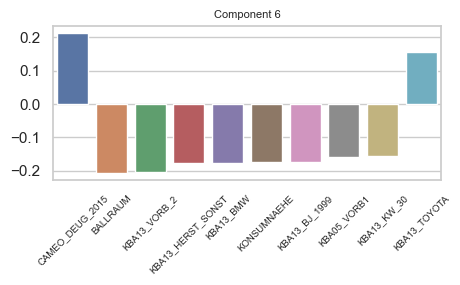



Top 10 Main features for Component 7:


,pca_weight,abs_pca_weight
KONSUMNAEHE,0.463100,0.463100
W_KEIT_KIND_HH,0.254670,0.254670
D19_KINDERARTIKEL_RZ,0.246025,0.246025
MOBI_REGIO,-0.222761,0.222761
D19_GESAMT_ANZ_12,-0.186827,0.186827
D19_GESAMT_OFFLINE_DATUM,0.167564,0.167564
D19_GESAMT_ANZ_24,0.163334,0.163334
D19_VERSAND_OFFLINE_DATUM,0.159669,0.159669
D19_VERSAND_ANZ_24,0.159238,0.159238
D19_VERSAND_ANZ_12,-0.158305,0.158305


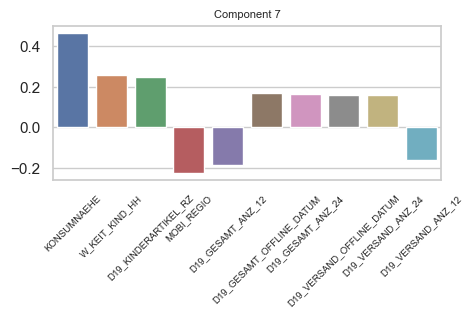



Top 10 Main features for Component 10:


,pca_weight,abs_pca_weight
BALLRAUM,-0.382287,0.382287
CAMEO_DEUG_2015,0.291579,0.291579
PLZ8_HHZ,-0.276360,0.276360
KBA05_ZUL3,-0.155933,0.155933
SEMIO_KULT,-0.151858,0.151858
KBA05_MAXAH,-0.149237,0.149237
KBA05_VORB1,0.148517,0.148517
KBA05_SEG9,-0.134856,0.134856
KBA05_VORB2,0.117192,0.117192
SEMIO_MAT,0.110890,0.110890


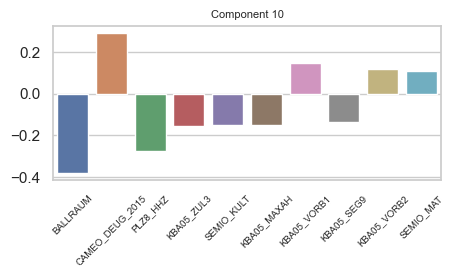

In [80]:
describe_cluster(cluster_id=11, n_top_components=10)